In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd, numpy as np

np.random.seed(42)
n = 250
df = pd.DataFrame({
    "customer_id": range(1001, 1001+n),
    "usage_gb": np.random.gamma(5, 2, n).round(2),          # positively skewed usage
    "call_mins": np.random.normal(350, 120, n).clip(50,900).round(0),
    "complaints": np.random.poisson(0.6, n),
    "plan_type": np.random.choice(["Prepaid","Postpaid"], n, p=[0.6,0.4]),
    "region": np.random.choice(["Delhi","Mumbai","Chennai","Kolkata"], n)
})
# create a realistic bill tied to usage, calls, plan, plus noise
base = 99 + 8*df["usage_gb"] + 0.2*df["call_mins"] + 30*df["complaints"]
base += np.where(df["plan_type"]=="Postpaid", 120, 0)
df["monthly_bill"] = (base + np.random.normal(0, 40, n)).round(2)
# churn probability higher for high complaints & low usage value users
logit = -2.2 + 0.35*df["complaints"] - 0.002*(df["monthly_bill"]-200) + 0.15*(df["usage_gb"]<5)
prob = 1/(1+np.exp(-logit))
df["churn"] = np.where(np.random.rand(n)<prob, "Yes", "No")

df.to_csv("billing_churn.csv", index=False)
print("Saved billing_churn.csv with shape:", df.shape)
df.head()


Saved billing_churn.csv with shape: (250, 8)


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No


In [4]:
import pandas as pd
df = pd.read_csv("billing_churn.csv")
print(df.shape); df.head()



(250, 8)


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No


In [6]:
import numpy as np

num_features = ["usage_gb","call_mins","complaints"]
X_num = df[num_features].copy()

# Targets
y_reg = df["monthly_bill"]               # regression target
y_clf = (df["churn"]=="Yes").astype(int) # classification target: Yes->1, No->0


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_num, y_reg, test_size=0.3, random_state=42)

# Use the same split indices for classification
_, _, y_clf_train, y_clf_test = train_test_split(
    X_num, y_clf, test_size=0.3, random_state=42)



=== REGRESSION ===
Features: ['usage_gb', 'call_mins', 'complaints']
Coefficients: {'usage_gb': 6.805, 'call_mins': 0.226, 'complaints': 34.865}
Intercept: 150.35
RMSE: 71.07


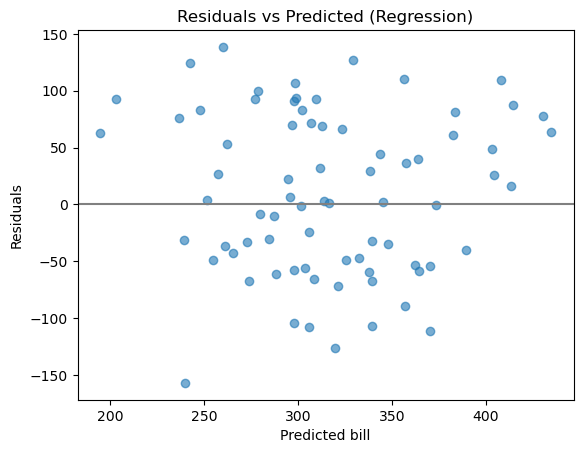


✅ Saved new file with predictions → billing_churn_with_predictions.csv
Preview:
   customer_id  usage_gb  call_mins  complaints plan_type   region  \
0         1001     11.65      427.0           2   Prepaid  Chennai   
1         1002      8.75      514.0           0   Prepaid  Kolkata   
2         1003      8.36      234.0           1   Prepaid   Mumbai   
3         1004      8.36      432.0           0   Prepaid  Chennai   
4         1005     17.95      477.0           0   Prepaid    Delhi   

   monthly_bill churn  predicted_monthly_bill  
0        337.36    No                  396.07  
1        305.34    No                  326.31  
2        245.95    No                  295.10  
3        248.32    No                  305.08  
4        374.76    No                  380.54  


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

reg = LinearRegression().fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))

print("=== REGRESSION ===")
print("Features:", num_features)
print("Coefficients:", dict(zip(num_features, reg.coef_.round(3)))) # how of each of the parameter increase will impact the billing.
print("Intercept:", round(reg.intercept_, 2))
print("RMSE:", round(rmse, 2))

import matplotlib.pyplot as plt
resid = y_reg_test - y_reg_pred
plt.scatter(y_reg_pred, resid, alpha=0.6)
plt.axhline(0, color='gray')
plt.xlabel("Predicted bill"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Regression)")
plt.show()

df = pd.read_csv("billing_churn.csv")

X_all = df[num_features]
df["predicted_monthly_bill"] = reg.predict(X_all).round(2)
output_path = "billing_churn_with_predictions.csv"
df.to_csv(output_path, index=False)

print(f"\n✅ Saved new file with predictions → {output_path}")
print("Preview:")
print(df.head())


In [22]:
# --- imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# --- load data ---
df = pd.read_csv("billing_churn_with_predictions.csv")  # or billing_churn.csv if you prefer
num_features = ["usage_gb", "call_mins", "complaints"]
cat_features = ["plan_type", "region"]

# --- prepare X and y (classification target) ---
X = df[num_features + cat_features]
y = (df["churn"] == "Yes").astype(int)

# --- train/test split (keep it reproducible) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --- Preprocessing: scale numerics, one-hot encode categoricals; ignore unseen categories at inference time ---
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features)
])

# --- pipeline: preprocessor + classifier ---
clf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear", random_state=42))
])

# --- train ---
clf_pipeline.fit(X_train, y_train)

# --- evaluate on test set ---
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print("=== CLASSIFICATION (Pipeline) ===")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed report:\n", classification_report(y_test, y_pred, target_names=["No churn", "Churn"], zero_division=0))

# --- Predict churn probability for ALL rows in original df ---
X_all = df[num_features + cat_features]   # same columns, same order
df["churn_probability"] = clf_pipeline.predict_proba(X_all)[:, 1].round(3)
df["predicted_churn"] = (df["churn_probability"] >= 0.5).astype(int)

# --- save updated dataset ---
out = "billing_churn_with_predictions_churn_fixed.csv"
df.to_csv(out, index=False)
print(f"\n✅ Saved updated file → {out}")
print(df[["customer_id", "monthly_bill", "churn", "churn_probability", "predicted_churn"]].head())


=== CLASSIFICATION (Pipeline) ===
Accuracy: 0.587
Precision: 0.038  Recall: 0.143  F1: 0.061

Confusion matrix:
 [[43 25]
 [ 6  1]]

Detailed report:
               precision    recall  f1-score   support

    No churn       0.88      0.63      0.74        68
       Churn       0.04      0.14      0.06         7

    accuracy                           0.59        75
   macro avg       0.46      0.39      0.40        75
weighted avg       0.80      0.59      0.67        75


✅ Saved updated file → billing_churn_with_predictions_churn_fixed.csv
   customer_id  monthly_bill churn  churn_probability  predicted_churn
0         1001        337.36    No              0.518                1
1         1002        305.34    No              0.151                0
2         1003        245.95    No              0.811                1
3         1004        248.32    No              0.381                0
4         1005        374.76    No              0.252                0


C:\Users\Priyanshi\OneDrive\anaconda\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
print("\nSUMMARY")
print(f"Regression RMSE: {rmse:.2f}")
print(f"Classification Acc: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")



SUMMARY
Regression RMSE: 71.07
Classification Acc: 0.547 | Precision: 0.114 | Recall: 0.571 | F1: 0.190


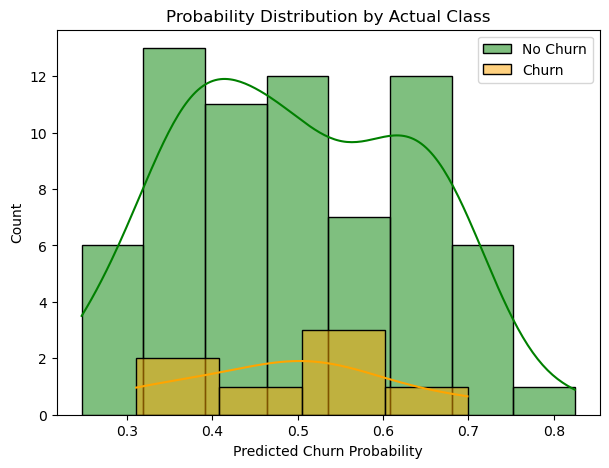

In [16]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.histplot(y_proba[y_clf_test==0], color='green', label='No Churn', kde=True)
sns.histplot(y_proba[y_clf_test==1], color='orange', label='Churn', kde=True)
plt.xlabel("Predicted Churn Probability")
plt.title("Probability Distribution by Actual Class")
plt.legend()
plt.show()


=== IMPROVED REGRESSION ===
Features: ['usage_gb', 'call_mins', 'complaints', 'plan_type_Prepaid', 'region_Delhi', 'region_Kolkata', 'region_Mumbai']
Intercept: 216.72
RMSE: 37.08

✅ Saved improved file → billing_churn_with_predictions_v2.csv
   customer_id  usage_gb  call_mins  complaints plan_type   region  \
0         1001     11.65      427.0           2   Prepaid  Chennai   
1         1002      8.75      514.0           0   Prepaid  Kolkata   
2         1003      8.36      234.0           1   Prepaid   Mumbai   
3         1004      8.36      432.0           0   Prepaid  Chennai   
4         1005     17.95      477.0           0   Prepaid    Delhi   

   monthly_bill churn  predicted_monthly_bill_v2  
0        337.36    No                     335.29  
1        305.34    No                     281.16  
2        245.95    No                     241.23  
3        248.32    No                     252.86  
4        374.76    No                     349.83  


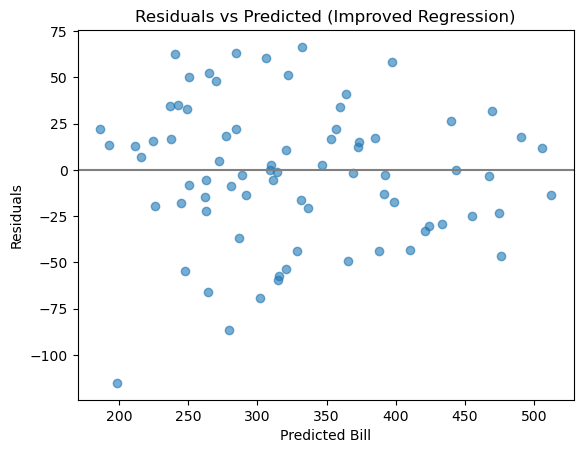

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# --- Load data ---
df = pd.read_csv("billing_churn.csv")

# --- Features & Target ---
num_features = ["usage_gb", "call_mins", "complaints"]
cat_features = ["plan_type", "region"]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)

# Define X and y
X = df_encoded.drop(columns=["customer_id", "monthly_bill", "churn"])
y = df_encoded["monthly_bill"]

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Train model ---
reg = LinearRegression()
reg.fit(X_train, y_train)

# --- Predict ---
y_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== IMPROVED REGRESSION ===")
print("Features:", list(X.columns))
print("Intercept:", round(reg.intercept_, 2))
print("RMSE:", round(rmse, 2))

# --- Save predictions ---
df["predicted_monthly_bill_v2"] = reg.predict(X).round(2)
df.to_csv("billing_churn_with_predictions_v2.csv", index=False)

print(f"\n✅ Saved improved file → billing_churn_with_predictions_v2.csv")
print(df.head())

# --- Optional residual plot ---
import matplotlib.pyplot as plt
resid = y_test - y_pred
plt.scatter(y_pred, resid, alpha=0.6)
plt.axhline(0, color='gray')
plt.xlabel("Predicted Bill")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Improved Regression)")
plt.show()